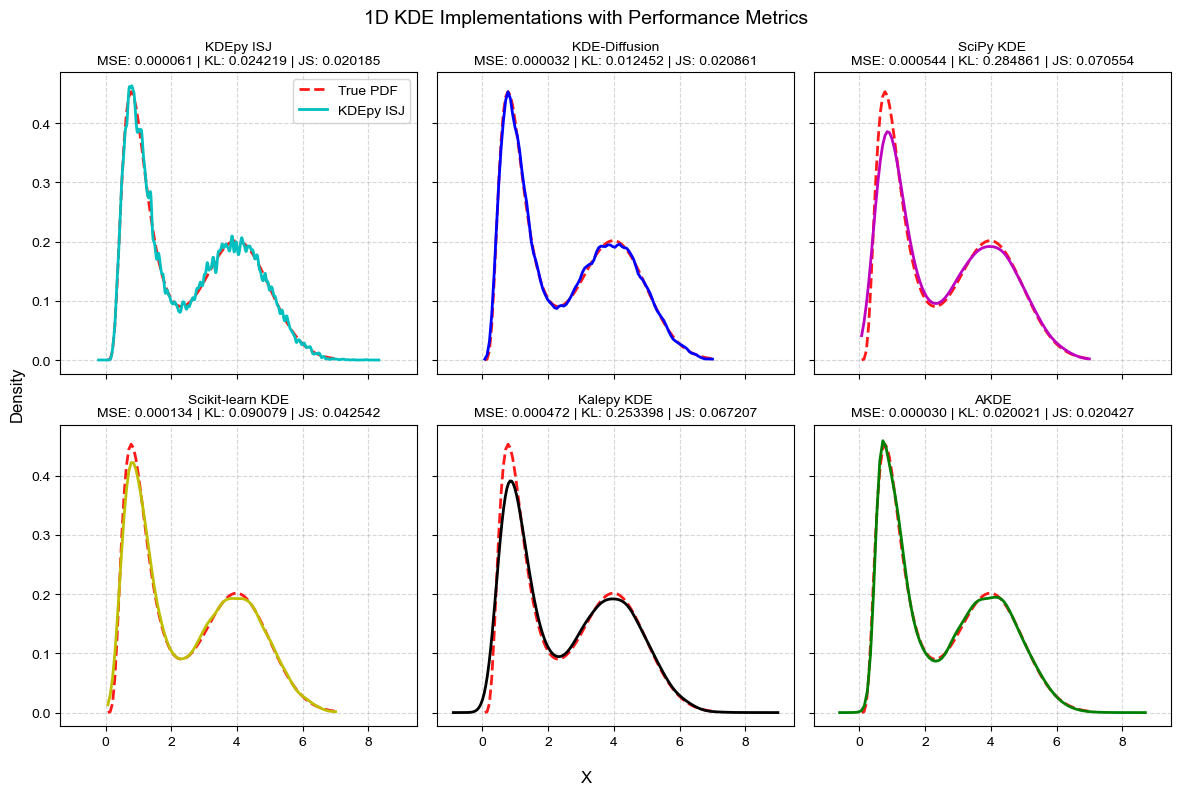

In [2]:
# Comparison of 1D KDE Implementations with Performance Metrics
# Install dependencies: pip install kalepy kde_diffusion kdepy 
import numpy as np
import matplotlib.pyplot as plt
import kalepy as kale
from KDEpy import FFTKDE
from kde_diffusion import kde1d
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from akde import akde
from scipy.spatial.distance import jensenshannon

# Set random seed for reproducibility
np.random.seed(12345)

# Number of samples
NUM = int(1e4)

# Generate data: Mixture of normal and log-normal distributions
d1 = np.random.normal(4.0, 1.0, NUM)
d2 = np.random.lognormal(0, 0.5, NUM)
data = np.concatenate([d1, d2])

# Define True PDF
xx = np.linspace(0.0, 7.0, 100)[1:]  # Avoid zero for log-normal stability
yy = 0.5 * np.exp(-(xx - 4.0) ** 2 / 2) / np.sqrt(2 * np.pi)
yy += 0.5 * np.exp(-np.log(xx) ** 2 / (2 * 0.5 ** 2)) / (0.5 * xx * np.sqrt(2 * np.pi))

# ======================== KDE Implementations ======================== #

mse_scores = {}
kl_scores = {}
js_scores = {}

# KDE-Diffusion

density, grid, bandwidth = kde1d(data)


# Resample KDE-Diffusion to `xx`
density_interp = np.interp(xx, grid, density)
density_interp /= np.trapezoid(density_interp, xx) 


# Kalepy KDE

points, kdensity = kale.density(data, probability=True)

# KDEpy (Improved Sheather Jones - ISJ)

x, y_kdepy = FFTKDE(kernel='gaussian', bw='ISJ').fit(data).evaluate()

# SciPy KDE

scipy_kde = gaussian_kde(data, bw_method='silverman')
y_scipy = scipy_kde(xx)


# Scikit-learn KDE

sklearn_kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(data[:, None])
log_dens = sklearn_kde.score_samples(xx[:, None])
y_sklearn = np.exp(log_dens)


# AKDE (Adaptive Kernel Density Estimation)

data_reshaped = data.reshape(-1, 1)  # AKDE expects 2D numpy input
akde_pdf, akde_grid, akde_bandwidth = akde(data_reshaped)

# ======================== COMPUTE ACCURACY METRICS ======================== #

kde_methods = {
    "KDEpy ISJ": (x, y_kdepy, 'c'),
    "KDE-Diffusion": (xx, density_interp, 'b'),  
    "SciPy KDE": (xx, y_scipy, 'm'),
    "Scikit-learn KDE": (xx, y_sklearn, 'y'),
    "Kalepy KDE": (points, kdensity, 'k'),
    "AKDE": (akde_grid[0], akde_pdf, 'g'),
}

for method, (x_vals, y_vals, _) in kde_methods.items():
    # Resample KDE Estimate to match `xx` grid for fair comparison
    y_vals_interp = np.interp(xx, x_vals, y_vals)

    # Compute Metrics
    mse_scores[method] = np.mean((y_vals_interp - yy) ** 2)
    y_vals_clipped = np.clip(y_vals_interp, 1e-10, None)  # Avoid log(0) error
    kl_scores[method] = np.sum(yy * np.log(yy / y_vals_clipped))
    js_scores[method] = jensenshannon(yy, y_vals_interp)

# ======================== MULTIPANEL PLOTTING WITH METRICS ======================== #

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, (method, (x_vals, y_vals, color)) in enumerate(kde_methods.items()):
    ax = axes[i]
    
    # Plot True PDF (Reference)
    ax.plot(xx, yy, 'r--', alpha=0.9, lw=2, label="True PDF")
    
    # Plot KDE Estimate
    ax.plot(x_vals, y_vals, color=color, lw=2, label=method)
    
    # Retrieve Metrics
    mse = mse_scores.get(method, np.nan)
    kl = kl_scores.get(method, np.nan)
    js = js_scores.get(method, np.nan)

    # Formatting
    ax.set_title(f"{method}\nMSE: {mse:.6f} | KL: {kl:.6f} | JS: {js:.6f}", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Show legend only in the first panel
    if i == 0:
        ax.legend(fontsize=10)

# Set common labels
fig.suptitle("1D KDE Implementations with Performance Metrics", fontsize=14)
fig.supxlabel("X", fontsize=12)
fig.supylabel("Density", fontsize=12)

# Adjust layout for readability
plt.tight_layout()

# Save Figures
plt.savefig("1D_KDEs_with_Metrics.pdf", transparent=True, dpi=600, bbox_inches="tight")
plt.savefig("1D_KDEs_with_Metrics.png", transparent=True, dpi=600, bbox_inches="tight")
# Show Plot
plt.show()

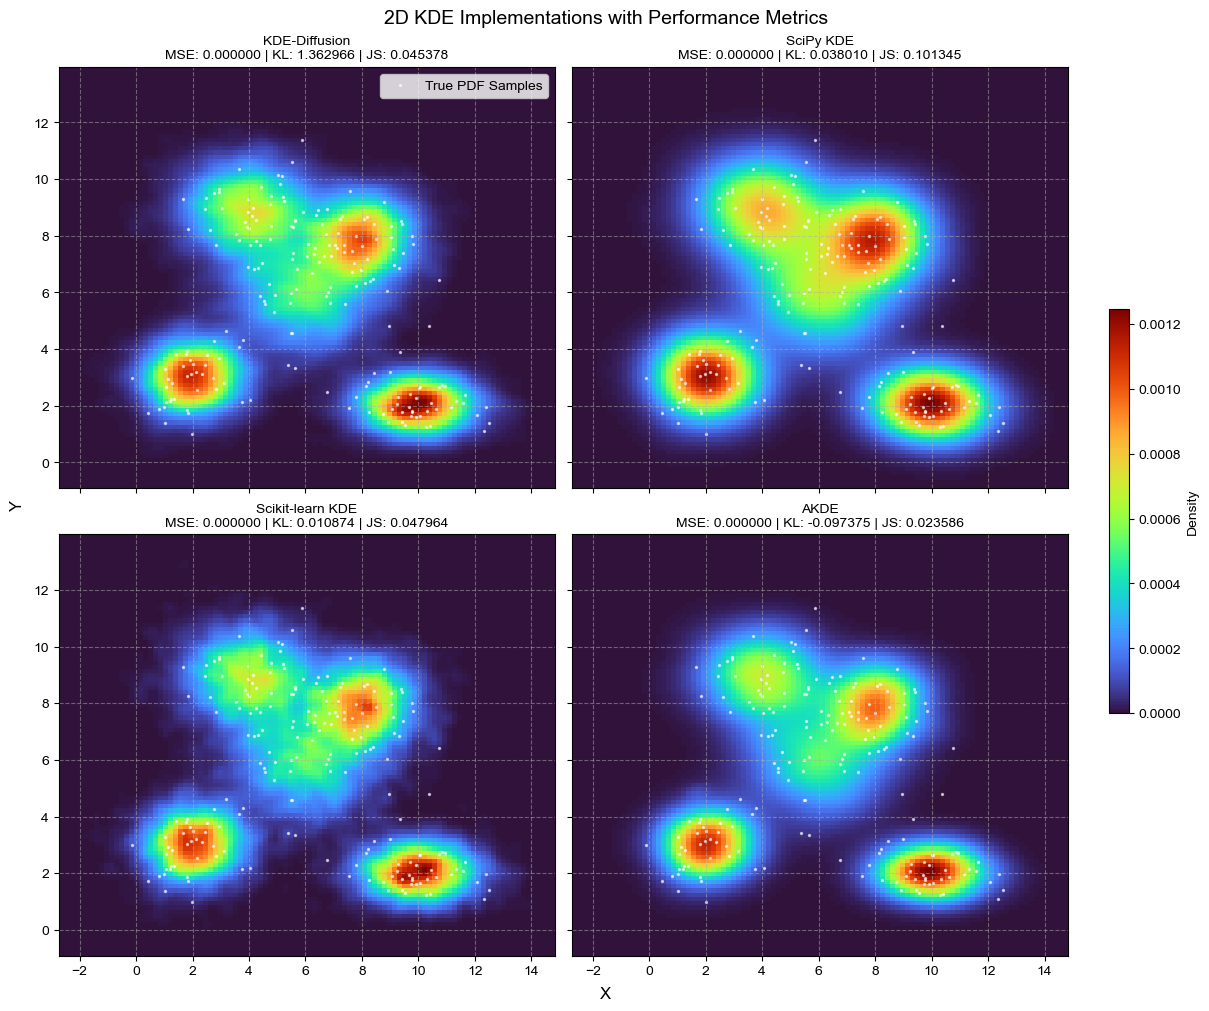

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from kde_diffusion import kde2d
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from akde import akde
from scipy.spatial.distance import jensenshannon
from scipy.interpolate import RegularGridInterpolator

# Set random seed for reproducibility
np.random.seed(12345)

# Number of samples 
NUM = int(20000)

# Generate Penta-Modal 2D Data (Five Gaussian Distributions)
means = [(2, 3), (6, 6), (10, 2), (4, 9), (8, 8)]
std_devs = [(1.0, 0.8), (1.5, 1.2), (1.2, 0.6), (1.3, 1.0), (1.1, 0.9)]
num_per_cluster = NUM // len(means)

data_x, data_y = [], []

for (mx, my), (sx, sy) in zip(means, std_devs):
    x = np.random.normal(mx, sx, num_per_cluster)
    y = np.random.normal(my, sy, num_per_cluster)
    data_x.append(x)
    data_y.append(y)

# Merge all clusters into a single dataset
data_x = np.concatenate(data_x)
data_y = np.concatenate(data_y)
data = np.vstack([data_x, data_y]).T

# Define a common grid for evaluation (100x100)
x_grid = np.linspace(data_x.min() - 1, data_x.max() + 1, 100)
y_grid = np.linspace(data_y.min() - 1, data_y.max() + 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

# Compute True PDF (Penta-Modal Gaussian Mixture)
true_pdf = np.zeros_like(X_mesh)
for (mx, my), (sx, sy) in zip(means, std_devs):
    true_pdf += (
        np.exp(-((X_mesh - mx) ** 2) / (2 * sx**2)) / np.sqrt(2 * np.pi * sx**2) *
        np.exp(-((Y_mesh - my) ** 2) / (2 * sy**2)) / np.sqrt(2 * np.pi * sy**2)
    )

# Normalize the true PDF to sum to 1
true_pdf /= np.sum(true_pdf)

# ======================== KDE IMPLEMENTATIONS ======================== #

kde_results = {}
mse_scores = {}
kl_scores = {}
js_scores = {}

# KDE-Diffusion (`kde2d`)

density_2D, grid, bandwidth = kde2d(data_x, data_y)
x_kde, y_kde = np.unique(grid[0]), np.unique(grid[1]) 
density_2D = (density_2D.T) / density_2D.sum()  
interp_func = RegularGridInterpolator((x_kde, y_kde), density_2D.T, method='linear', bounds_error=False, fill_value=0)
kde_results["KDE-Diffusion"] = interp_func((X_mesh, Y_mesh))


# SciPy KDE

scipy_kde = gaussian_kde(data.T, bw_method="silverman")
density_2D = scipy_kde(np.vstack([X_mesh.ravel(), Y_mesh.ravel()])).reshape(100, 100)
density_2D /= np.sum(density_2D) 
kde_results["SciPy KDE"] = density_2D


# Scikit-learn KDE

sklearn_kde = KernelDensity(kernel="gaussian", bandwidth='silverman').fit(data)
log_dens = sklearn_kde.score_samples(np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T)
density_2D = np.exp(log_dens).reshape(100, 100)
density_2D /= np.sum(density_2D) 
kde_results["Scikit-learn KDE"] = density_2D


# AKDE 

akde_pdf, meshgrids, _ = akde(data)  
x_akde, y_akde = np.unique(meshgrids[0]), np.unique(meshgrids[1]) 
density_2D = akde_pdf.reshape(meshgrids[0].shape)
density_2D /= np.sum(density_2D) 
interp_func = RegularGridInterpolator((x_akde, y_akde), density_2D.T, method='linear', bounds_error=False, fill_value=0)
kde_results["AKDE"] = interp_func((X_mesh, Y_mesh))


# ======================== EVALUATE KDE ACCURACY ======================== #

for method, kde_density in kde_results.items():
    mse_scores[method] = np.mean((kde_density - true_pdf) ** 2)
    kde_density = np.clip(kde_density, 1e-10, None)  # Avoid log(0)
    kl_scores[method] = np.sum(true_pdf * np.log(true_pdf / kde_density))
    js_scores[method] = jensenshannon(true_pdf.ravel(), kde_density.ravel())

# ======================== MULTIPANEL PLOTTING WITH METRICS ======================== #

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

for i, (method, density_2D) in enumerate(kde_results.items()):
    ax = axes[i]
    im = ax.imshow(
        density_2D, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
        origin="lower", cmap="turbo", aspect="auto"
    )
    
    # Scatter plot of a subset of the data points
    ax.scatter(data_x[::100], data_y[::100], color="white", s=2, alpha=0.6, label="True PDF Samples")

    # Title with KDE method and metrics
    
    mse = mse_scores[method]
    kl = kl_scores[method]
    js = js_scores[method]

    ax.set_title(f"{method}\nMSE: {mse:.6f} | KL: {kl:.6f} | JS: {js:.6f}", fontsize=10)
    ax.set_xlim(x_grid.min(), x_grid.max())
    ax.set_ylim(y_grid.min(), y_grid.max())
    ax.grid(True, linestyle="--", alpha=0.5)

    if i == 0:
        ax.legend(fontsize=10)

fig.suptitle("2D KDE Implementations with Performance Metrics", fontsize=14)
fig.supxlabel("X", fontsize=12)
fig.supylabel("Y", fontsize=12)

cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Density")

plt.savefig("2D_KDEs_with_Metrics.png", transparent=True, dpi=600, bbox_inches="tight")
plt.savefig("2D_KDEs_with_Metrics.pdf", transparent=True, dpi=600, bbox_inches="tight")
plt.show()